In [1]:
# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import numbers
import time

2.0.0-alpha0


In [52]:
def make_circles(grid = 11, n_data = 10):    
    max_distance = int((grid-1)/2)
    radii = np.random.randint(max_distance/2.,max_distance,size = (n_data, 2))
    radii = radii.flatten()
    distance = np.random.randint(max_distance, size = n_data)
    distances = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in distance])
    radii1 = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in radii[::2]])
    radii2 = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in radii[1::2]])
    circle = np.zeros((n_data, grid, grid))
    circlex = np.zeros((grid, grid))
    circley = np.zeros((grid, grid))
    circlex[:][:][:] = np.arange(grid)
    circley[:][:][:] = np.transpose(circlex)
    x1 = circley - max_distance + distances/2
    x2 = circley - max_distance - distances/2
    y = circlex - max_distance
    position1 = np.sqrt(x1**2+y**2)
    position2 = np.sqrt(x2**2+y**2)
    fill1 = position1 <= radii1
    fill2 = position2 <= radii2
    p1 = np.exp((-1./2.)*(3.*position1/radii1)**2.)
    p2 = np.exp((-1./2.)*(3.*position2/radii2)**2.)
    p1 = np.where(fill1, p1, 0.0)
    p2 = np.where(fill2, p2, 0.0)
    circles = p1 + p2
    circles = circles.reshape(n_data, grid**2)
    radii = radii.reshape(n_data, 2)
    distances = distances.reshape(n_data*grid**2,1)[::grid**2]
    return circles, radii, distances
    

Make data:

In [53]:
grid = 100
n_data = 500
toc = time.clock()
circleData, radiiLabels, distanceLabels = make_circles(grid, n_data)
tic = time.clock()
print(tic-toc)

0.578274


Print a plot of data to see what it looks like!

radius = 
[29 40]
distance between centers = 
[41.]


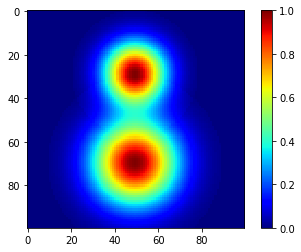

In [54]:
display = circleData[60].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("radius = ")
print(radiiLabels[60])
print("distance between centers = ")
print(distanceLabels[60])
plt.colorbar()

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

In [55]:
distanceData = circleData#.reshape(n_data, grid, grid, 1)

split = int(0.8*len(circleData))
train_data = distanceData[:split]
train_labels = distanceLabels[:split]
print (train_data.shape)
test_data = distanceData[split:]
print(test_data.shape)
test_labels = distanceLabels[split:]

(400, 10000)
(100, 10000)


Build DNN:

In [56]:
def build_model():
  model = keras.Sequential([
    #layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.AveragePooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error', 'mean_absolute_error'])
  return model

Initialize model:

In [57]:
model_circ = build_model()

Test model's prediction $before$ training:

In [58]:
example_batch = train_data[:10]
example_labels = train_labels[:10]
example_result = model_circ.predict(example_batch)
results = model_circ.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 5ms/sample - loss: 468.8598 - mean_squared_error: 468.8598 - mean_absolute_error: 17.8662


array([[ 0.02850026],
       [-0.03982331],
       [ 0.01041251],
       [ 0.02857837],
       [ 0.00685872],
       [ 0.21562156],
       [ 0.08575185],
       [-0.01273987],
       [-0.01409005],
       [ 0.02866919]], dtype=float32)

Now train! (warning: if building CNN, computer tends to get loud)

In [59]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    print('.', end='')
    
EPOCHS = 100

history = model_circ.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2,
  callbacks=[PrintDot()])

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 0s 500us/sample - loss: 412.9261 - mean_squared_error: 412.9261 - mean_absolute_error: 16.9084 - val_loss: 179.3515 - val_mean_squared_error: 179.3515 - val_mean_absolute_error: 11.3492
Epoch 2/100
320/320 [==============================] - 0s 152us/sample - loss: 111.6076 - mean_squared_error: 111.6076 - mean_absolute_error: 8.5398 - val_loss: 55.1176 - val_mean_squared_error: 55.1176 - val_mean_absolute_error: 5.5437
Epoch 3/100
320/320 [==============================] - 0s 145us/sample - loss: 50.1949 - mean_squared_error: 50.1949 - mean_absolute_error: 5.5042 - val_loss: 43.9321 - val_mean_squared_error: 43.9321 - val_mean_absolute_error: 5.7285
Epoch 4/100
320/320 [==============================] - 0s 131us/sample - loss: 36.4678 - mean_squared_error: 36.4678 - mean_absolute_error: 4.9302 - val_loss: 23.6458 - val_mean_squared_error: 23.6458 - val_mean_absolute_error: 3.7555
Epoch 5

320/320 [==============================] - 0s 159us/sample - loss: 1.2100 - mean_squared_error: 1.2100 - mean_absolute_error: 0.8137 - val_loss: 1.2621 - val_mean_squared_error: 1.2621 - val_mean_absolute_error: 0.8786
Epoch 36/100
320/320 [==============================] - 0s 138us/sample - loss: 1.0815 - mean_squared_error: 1.0815 - mean_absolute_error: 0.7906 - val_loss: 1.0934 - val_mean_squared_error: 1.0934 - val_mean_absolute_error: 0.8064
Epoch 37/100
320/320 [==============================] - 0s 156us/sample - loss: 1.1318 - mean_squared_error: 1.1318 - mean_absolute_error: 0.8193 - val_loss: 1.0191 - val_mean_squared_error: 1.0191 - val_mean_absolute_error: 0.7505
Epoch 38/100
320/320 [==============================] - 0s 131us/sample - loss: 1.1598 - mean_squared_error: 1.1598 - mean_absolute_error: 0.8014 - val_loss: 1.0155 - val_mean_squared_error: 1.0155 - val_mean_absolute_error: 0.7677
Epoch 39/100
320/320 [==============================] - 0s 134us/sample - loss: 0.920

320/320 [==============================] - 0s 163us/sample - loss: 1.2548 - mean_squared_error: 1.2548 - mean_absolute_error: 0.8605 - val_loss: 0.8096 - val_mean_squared_error: 0.8096 - val_mean_absolute_error: 0.7062
Epoch 71/100
320/320 [==============================] - 0s 149us/sample - loss: 0.7233 - mean_squared_error: 0.7233 - mean_absolute_error: 0.6677 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - val_mean_absolute_error: 0.5575
Epoch 72/100
320/320 [==============================] - 0s 141us/sample - loss: 0.4355 - mean_squared_error: 0.4355 - mean_absolute_error: 0.4805 - val_loss: 0.5053 - val_mean_squared_error: 0.5053 - val_mean_absolute_error: 0.5369
Epoch 73/100
320/320 [==============================] - 0s 128us/sample - loss: 0.3943 - mean_squared_error: 0.3943 - mean_absolute_error: 0.4496 - val_loss: 0.5001 - val_mean_squared_error: 0.5001 - val_mean_absolute_error: 0.5366
Epoch 74/100
320/320 [==============================] - 0s 129us/sample - loss: 0.432

Now make a plot that shows the pregression of accuracy through each training epoch.

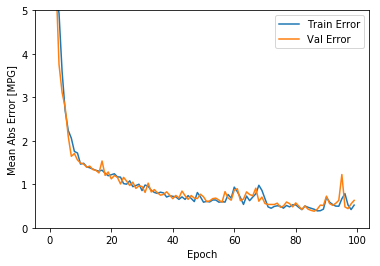

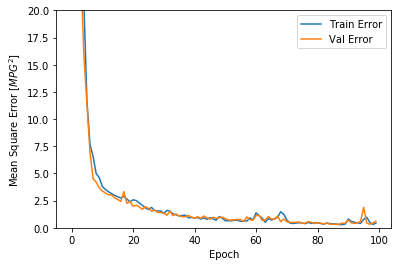

In [60]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

Now have the model train with "early stopping". the tensorflow "early stopping" function has the training stop according to a monitor. In our case, we are stopping it when the monitor sees an insufficient change in variable loss within the last ten epochs.


....................................................................................................

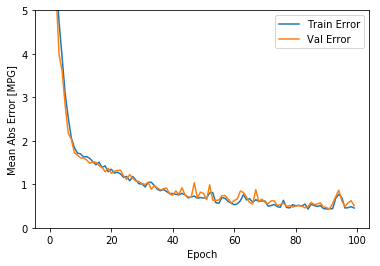

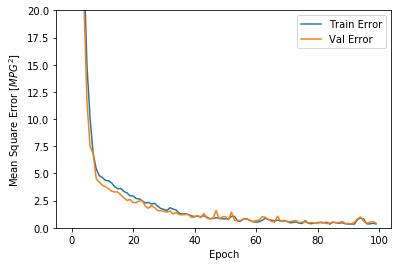

In [61]:
model_circ = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history_earlyStop = model_circ.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history_earlyStop)

In [62]:
results = model_circ.evaluate(test_data, test_labels)

100/100 [==============================] - 0s 82us/sample - loss: 0.4694 - mean_squared_error: 0.4694 - mean_absolute_error: 0.5110


Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

Multilayer perceptron: initial MSE ~ 656.7611; final MSE ~ 0.8408.

CNN: initial MSE ~ 1170.2961; final MSE ~ 1.6238.

CNN w/ MaxPooling layer: initial MSE ~ 1167.0415; final ~ MSE 0.4101.

CNN w/ AveragePooling layer: initial MSE ~ 804.62; final ~ 0.78.

100/100 [==============================] - 0s 101us/sample - loss: 0.4694 - mean_squared_error: 0.4694 - mean_absolute_error: 0.5110


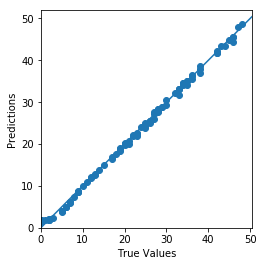

In [63]:
test_predictions = model_circ.predict(test_data)
results = model_circ.evaluate(test_data, test_labels)
plt.scatter(test_labels.flatten(), test_predictions.flatten())
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Now let's use the same network to predict radii!

To use CNN, uncomment "circleData = circleData.reshape(n_data, grid, grid, 1)"

In [35]:
#circleData = circleData.reshape(n_data, grid, grid, 1)
split = int(0.8*len(circleData))
train_data_rad = circleData[:split]
train_labels_rad = radiiLabels[:split]
test_data_rad = circleData[split:]
test_labels_rad = radiiLabels[split:]

To implement basic CNN, uncomment "layers.Conv2D(32, (3, 3), activation='relu')," and "layers.Flatten()"

To implement MaxPooling CNN, uncomment "layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),"


In [36]:
def build_model_rad():
  model = keras.Sequential([
    #layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.AveragePooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'), 
    #layers.MaxPooling2D((2, 2)),
    #layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(2)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_absolute_error', 'mean_squared_error', 'accuracy'])
  return model

In [37]:
model_rad = build_model_rad()
example_batch = train_data_rad[:10]
example_labels = train_labels_rad[:10]
example_result = model_rad.predict(example_batch)
results = model_rad.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 5ms/sample - loss: 898.2560 - mean_absolute_error: 27.7654 - mean_squared_error: 898.2560 - accuracy: 0.6000


array([[ 0.17449546,  0.07974399],
       [ 0.12608515,  0.11819054],
       [ 0.05521492, -0.02854218],
       [ 0.16112706,  0.06114392],
       [ 0.03449192,  0.08559342],
       [ 0.1072965 ,  0.1523971 ],
       [-0.09341439,  0.03275807],
       [ 0.30312502, -0.01353525],
       [-0.06457403,  0.10093299],
       [ 0.22244418,  0.07765828]], dtype=float32)


....................................................................................................

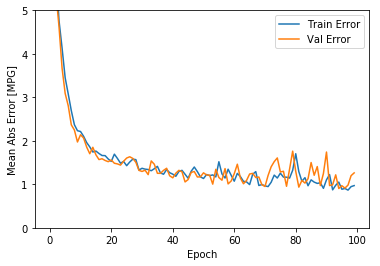

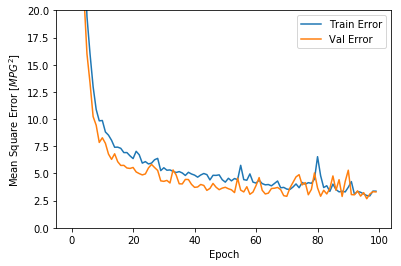

In [38]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    print('.', end='')
    
EPOCHS = 100

history = model_rad.fit(
  train_data_rad, train_labels_rad,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[PrintDot()])

plot_history(history)

For epochs = 1000, the above plot is a good example of how the error on the validation data can actually increase after a certain epoch-value is reached.


....................................................................................................

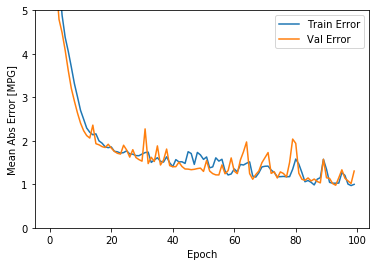

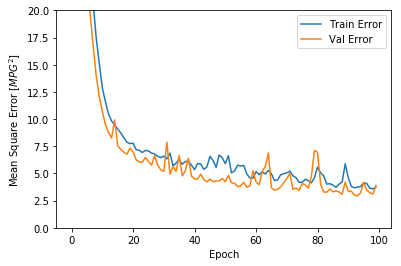

In [39]:
model = build_model_rad()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_data_rad, train_labels_rad, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [40]:
results = model.evaluate(test_data_rad, test_labels_rad)
print(results)


100/100 [==============================] - 0s 91us/sample - loss: 7.0701 - mean_absolute_error: 1.4771 - mean_squared_error: 7.0701 - accuracy: 0.9500
[7.070121939182282, 1.4770552, 7.0701222, 0.95]


Multilayer perceptron: final accuracy ~ 93%; initial MSE ~ 1019.7198 ; final MSE ~ 7.7464.

CNN: final accuracy ~ 96%; intitial MSE ~ 797.3132; final MSE ~ 4.2162.

CNN w/ MaxPooling layer: final accuracy ~ 97%; initial MSE ~ 800.8616; final MSE ~ 3.8766.

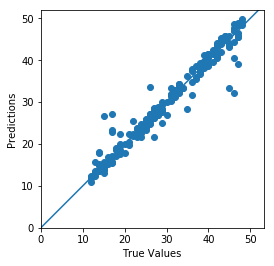

In [41]:
test_predictions_rad = model_rad.predict(test_data_rad).flatten()
plt.scatter(test_labels_rad, test_predictions_rad)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])